In [2]:
import warnings
import scienceplots
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import numpy as np
import gensim
import multiprocessing
import logging
import pandas as pd
import pprint
from adjustText import adjust_text
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

cores = multiprocessing.cpu_count()
assert gensim.models.doc2vec.FAST_VERSION > -1

warnings.filterwarnings('ignore')

plt.style.use(['science', 'ieee', 'grid', 'vibrant', 'no-latex'])


In [3]:
# !python3 ../src/features/clean-tokenize.py ../data/final/leg-7-to-14-with-parsed-texts.csv ../data/final/leg-7-to-14-with-clean-texts.csv

In [3]:
data = pd.read_csv('../data/all-data-clean-tokenized.csv')

In [4]:
# Specific changes to merge IU & UP, and keep only majority parties.
data['political_group'] = data['political_group'].str.replace('IU', 'UP')
groups = ['PSOE', 'PP', 'UP', 'VOX', 'CS']
data = data.loc[data['political_group'].isin(groups)]


data['pl'] = data['political_group'] + '-' + data['legislatura'].astype(str)
data['leg'] = 'L' + data['legislatura'].astype(str)
data = data.loc[data['text'] != 0].dropna().reset_index(drop=True)
data = data.loc[data['text'] != "['nan']"].reset_index(drop=True)
data.head(2)


,legislatura,fecha,objeto_iniciativa,numero_expediente,autores,nombre_sesion,orador,enlace_pdf,political_group,text,clean_text,phrases,pl,leg
0,7,2000-04-25,Propuesta de candidato a la Presidencia del Go...,080/000001/0000,"Juan Carlos I, Rey de España",Pleno,"Frutos Gras, Francisco (GIU)",https://www.congreso.es:443/public_oficiales/L...,UP,"Señora presidenta, seño- ras y señores diputad...","['candidato', 'primer', 'lugar', 'lógico', 're...","['candidato', 'primer_lugar', 'lógico', 'recon...",UP-7,L7
1,7,2000-04-25,Propuesta de candidato a la Presidencia del Go...,080/000001/0000,"Juan Carlos I, Rey de España",Pleno,"Martínez Noval, Luis (GS)",https://www.congreso.es:443/public_oficiales/L...,PSOE,"Señora presidenta, señoras y señores diputados...","['aznar', 'quiero', 'primeras', 'palabras', 'r...","['aznar', 'quiero', 'primeras_palabras', 'reco...",PSOE-7,L7


In [5]:
df = data[['pl', 'leg', 'phrases']]
df.columns = ['party', 'legislature', 'text']
df = df.loc[df['text'] != 0].dropna().reset_index(drop=True)
df = df.loc[df['text'] != "['nan']"].dropna().reset_index(drop=True)

In [6]:
f = df

f.legislature = f.legislature.replace({'L7': 'L07', 
                                       'L8': 'L08', 
                                       'L9': 'L09'})

fc = f.groupby('legislature').count()

In [7]:
f.loc[4].text

"['comenzar_intervención', 'permítanme', 'felicitar', 'nuevos', 'económicos', 'uso_palabra', 'cuales', 'debates', 'largo_legislatura', 'puntos_encuentro', 'primera_intervención', 'plenamente_satisfecho', 'grupos', 'parezcan', 'coincidir', 'promesa', 'hizo', 'campaña_electoral', 'puedo', 'satisfecho', 'campaña_electoral', 'dijimos', 'suprimir_iae', 'pequeños_empresarios', 'parece', 'quiere', 'sumar', 'agradezco', 'vivamente', 'grupos_parlamentarios', 'uniendo', 'absolutamente_convencido', 'absolutamente', 'comprometido', 'idea', 'suprimir_iae', 'suprimir_iae', 'fundamentalmente', 'autónomos', 'pequeños_negocios', 'emprendedores', 'traba', 'inicio', 'actividad', 'presentado', 'ajustarnos', 'exactamente', 'pretendemos', 'técnica', 'diciendo', 'queremos', 'eximir', 'iae', 'pequeños_negocios', 'autónomos_emprendedores', 'recogemos', 'modificación', 'garantizar', 'corporaciones_locales', 'van', 'perder', 'financiación', 'prestación_servicios', 'ello', 'refería', 'saura', 'poca', 'mucha', 'ni

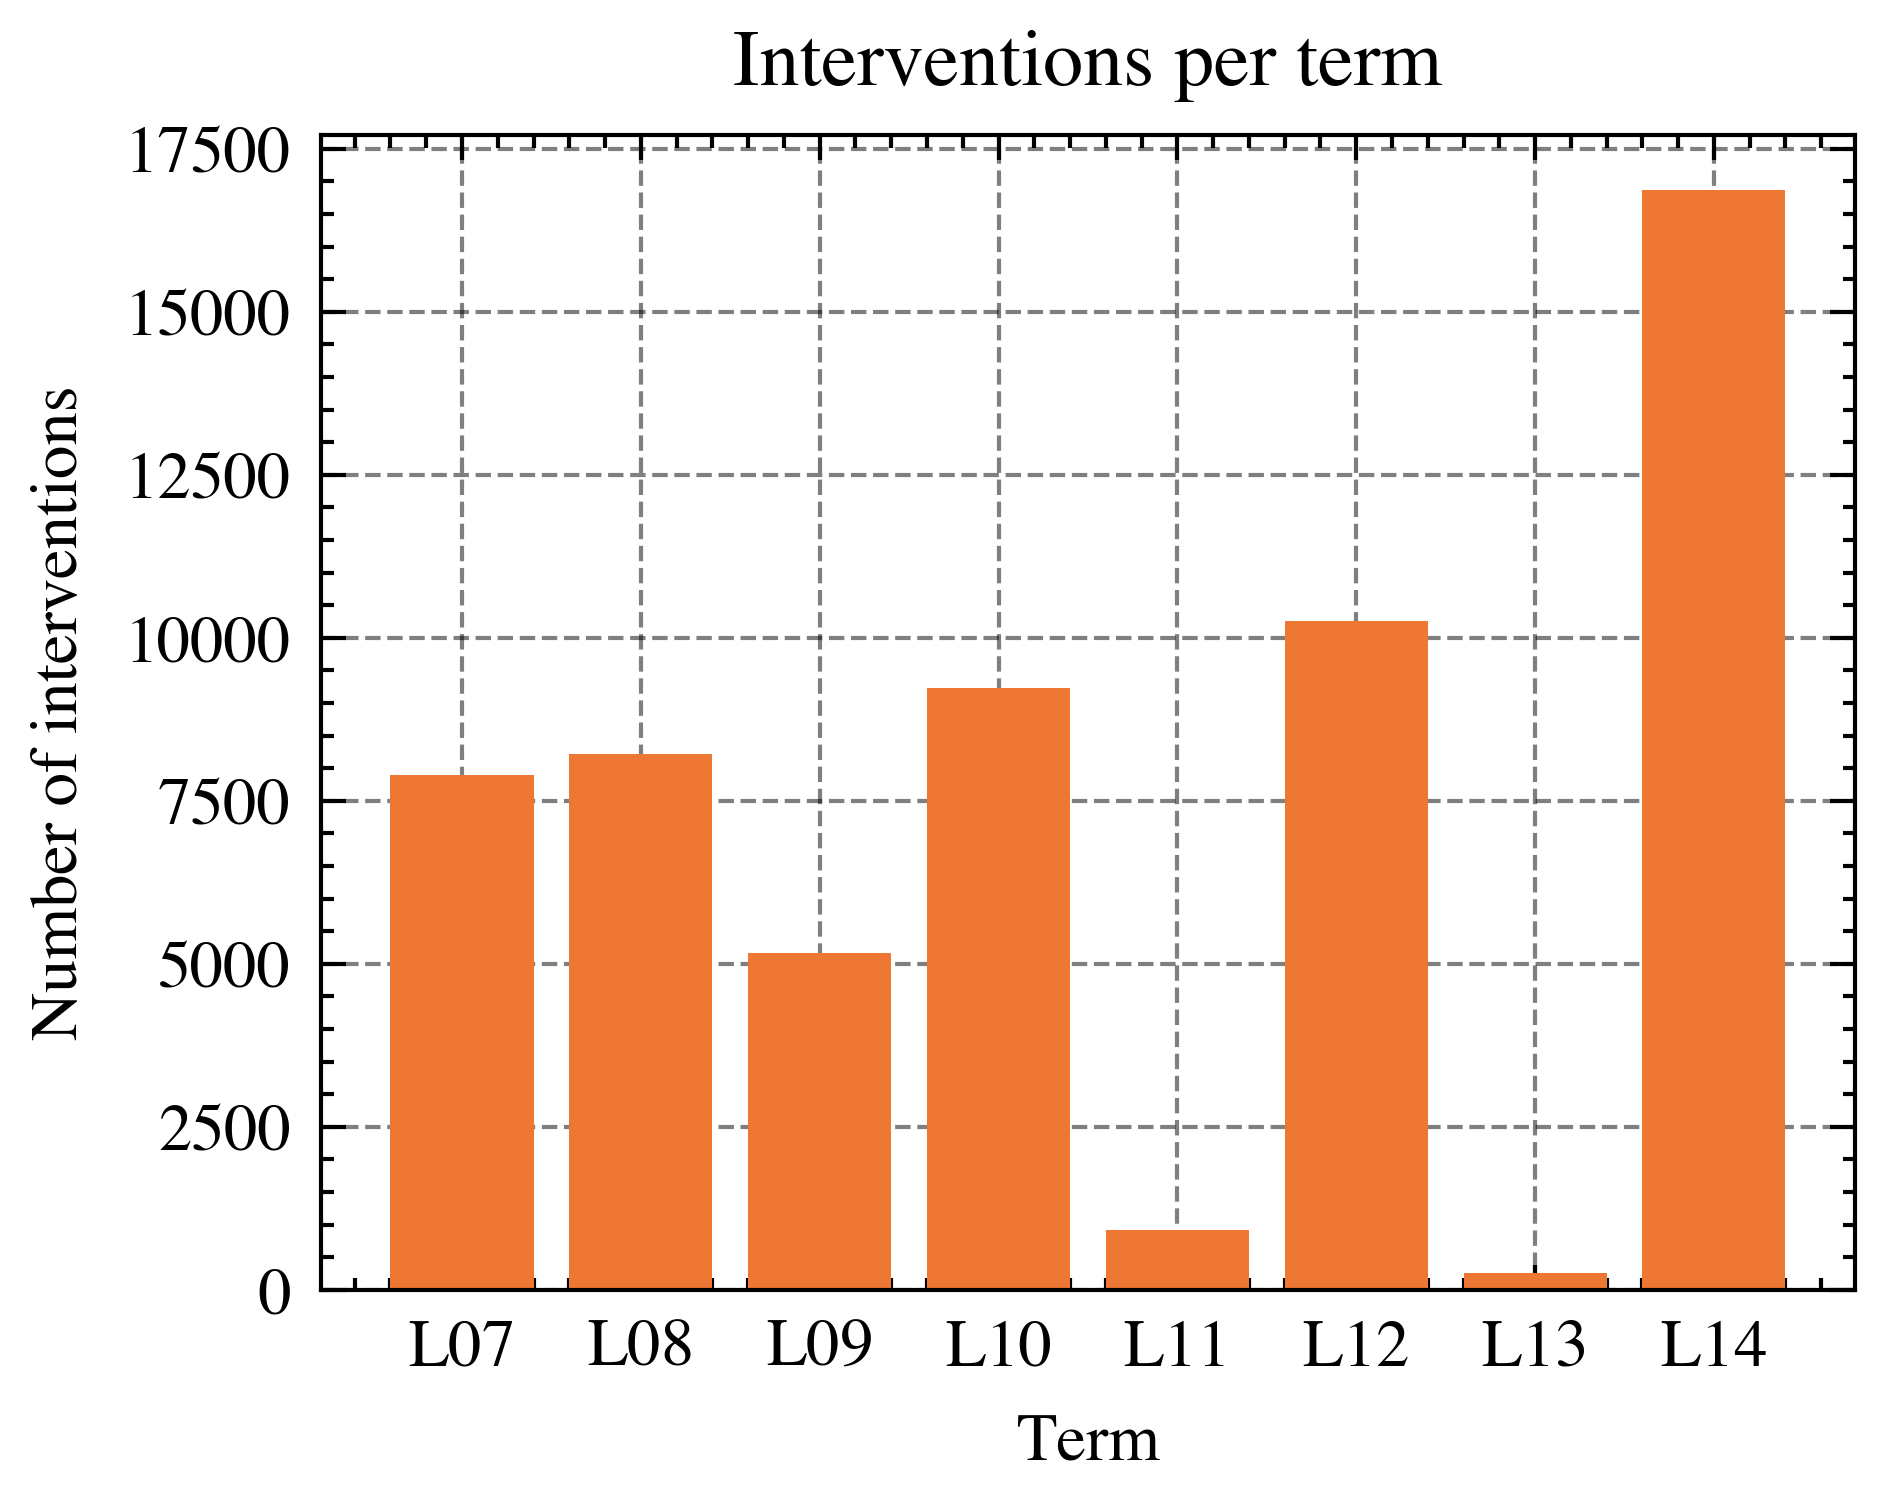

In [8]:
fig, ax = plt.subplots()

ax.bar(fc.index, fc.text)

#ax.set_xticks(range(2000, 2023, 2))
#ax.set_xticklabels(range(2000, 2023, 2), rotation=60)  # , ha='right')
#ax.grid(alpha=.3)

# remove tick marks
#ax.xaxis.set_tick_params(size=0)
#ax.yaxis.set_tick_params(size=0)

# Titles
ax.set_xlabel('Term')
ax.set_ylabel(f'Number of interventions')
ax.set_title('Interventions per term')
ax.title.set_weight('bold')

#ax.legend()


In [28]:
corpus = df.values.tolist()

def read_corpus(fname):
    for line in fname:
        # There was an error that made the words be a string instead of a list. 
        l = line[2].strip('][').split(', ')
        fixed_list = []
        for item in l:
            fixed_list.append(item.replace("'", ""))

        yield gensim.models.doc2vec.TaggedDocument(fixed_list, [line[0], line[1]])
        #yield gensim.models.doc2vec.TaggedDocument(fixed_list, [line[0]])

train_corpus = list(read_corpus(corpus))

In [29]:
model0 = gensim.models.doc2vec.Doc2Vec(dm=1, vector_size=50, window=20, min_count=5, workers=cores, epochs=20, negative=5, sample=0.001)
model0.build_vocab(train_corpus)
model0.train(train_corpus, total_examples=len(train_corpus), epochs=model0.epochs)

2023-04-18 18:22:29,846 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d50,n5,w20,mc5,s0.001,t8)', 'datetime': '2023-04-18T18:22:29.846096', 'gensim': '4.1.2', 'python': '3.8.13 (default, Mar 28 2022, 06:16:26) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2023-04-18 18:22:29,849 : INFO : collecting all words and their counts
2023-04-18 18:22:29,852 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2023-04-18 18:22:31,763 : INFO : PROGRESS: at example #10000, processed 4465791 words (2339125/s), 165170 word types, 7 tags
2023-04-18 18:22:33,840 : INFO : PROGRESS: at example #20000, processed 8321052 words (1857197/s), 214475 word types, 11 tags
2023-04-18 18:22:35,815 : INFO : PROGRESS: at example #30000, processed 12187267 words (1991369/s), 249771 word types, 15 tags
2023-04-18 18:22:37,186 : INFO : PROGRESS: at example #40000, processed 15346361 words (2305542/s), 275689 word types, 25 tags
2023-04-18 18

In [107]:
model0.save('../models/final.mdl')

2023-04-19 10:26:50,167 : INFO : Doc2Vec lifecycle event {'fname_or_handle': '../models/party_lvl-dm-m-d50-n5-w20-mc5-s0,001-t8-e20-bigrams-2tags-reduced-fixed-data.mdl', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-04-19T10:26:50.167401', 'gensim': '4.1.2', 'python': '3.8.13 (default, Mar 28 2022, 06:16:26) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'saving'}
2023-04-19 10:26:50,170 : INFO : not storing attribute cum_table
2023-04-19 10:26:50,473 : INFO : saved ../models/party_lvl-dm-m-d50-n5-w20-mc5-s0,001-t8-e20-bigrams-2tags-reduced-fixed-data.mdl


In [9]:
model = gensim.models.doc2vec.Doc2Vec.load('../models/final.mdl')


2023-05-30 11:09:29,953 : INFO : loading Doc2Vec object from ../models/final.mdl
2023-05-30 11:09:30,148 : INFO : loading dv recursively from ../models/final.mdl.dv.* with mmap=None
2023-05-30 11:09:30,150 : INFO : loading wv recursively from ../models/final.mdl.wv.* with mmap=None
2023-05-30 11:09:30,151 : INFO : setting ignored attribute cum_table to None
2023-05-30 11:09:31,647 : INFO : Doc2Vec lifecycle event {'fname': '../models/final.mdl', 'datetime': '2023-05-30T11:09:31.647493', 'gensim': '4.1.2', 'python': '3.8.13 (default, Mar 28 2022, 06:16:26) \n[Clang 12.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


In [10]:
len(model.wv.index_to_key)

159774

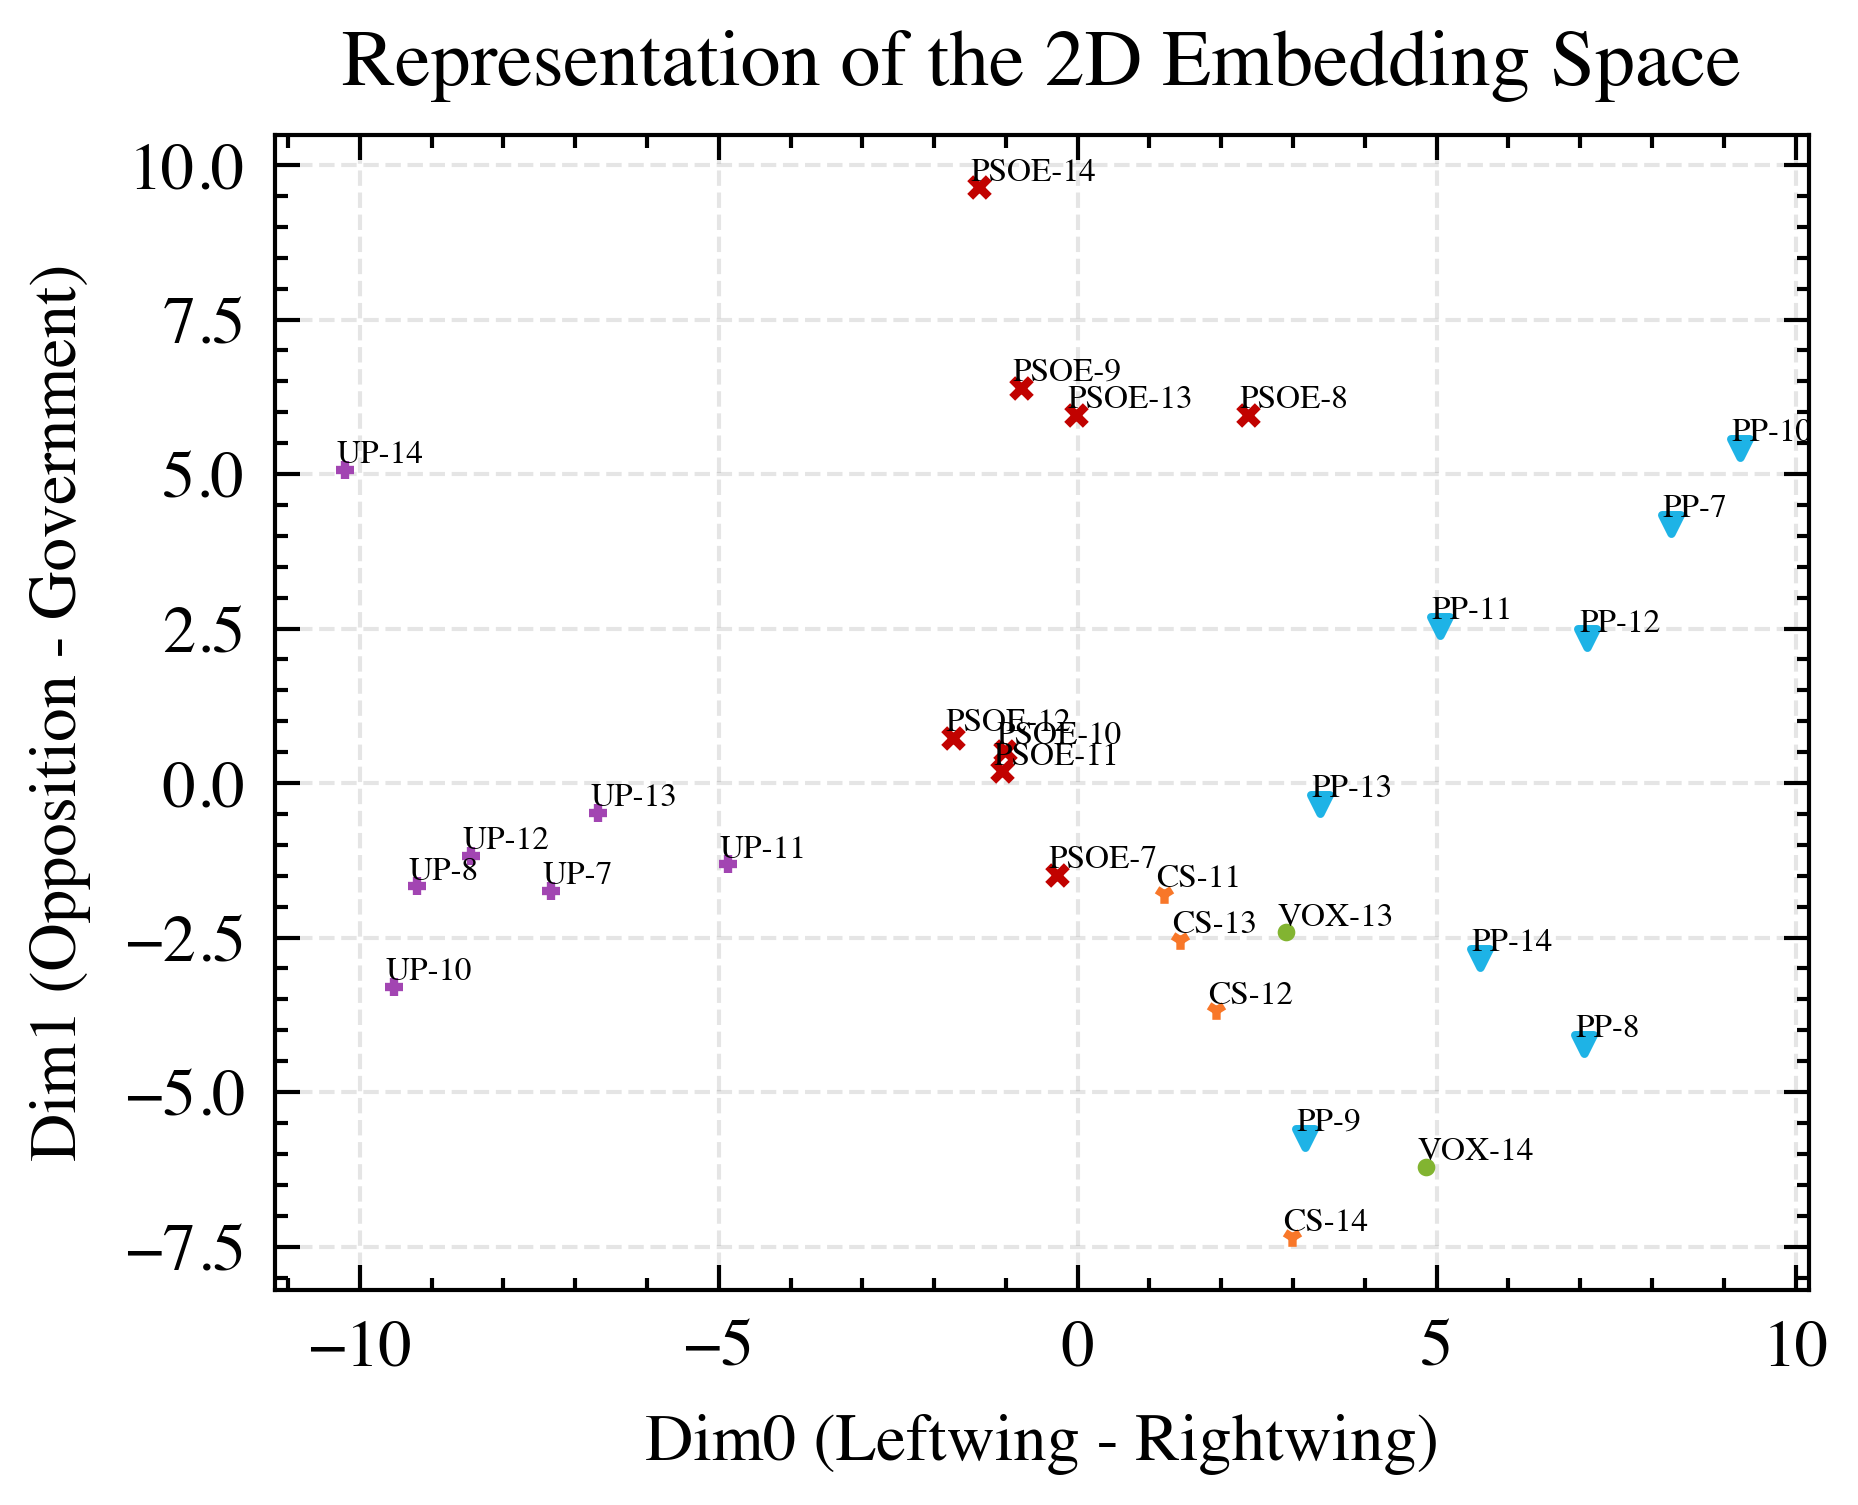

In [11]:
def reduce_dimension(model, method = 'pca', n=2):
    speakers = [item for item in model.dv.index_to_key]  # if '-' in item]
    S = len(speakers)
    M = model.vector_size
    z = np.zeros((S, M))

    for i in range(S):
        z[i, :] = model.dv[i]

    if method == 'pca':
        dr = PCA(n_components=n, random_state=123)
    elif method == 'tsne':
        dr = TSNE(n_components=n)
    else:
        print('Error: methods allowed are "pca" and "tsne".')
    
    Z = dr.fit_transform(z)
    Z = pd.DataFrame(Z)

    columns = []
    for i in range(n):
        columns.append(f'dim{i}')
    Z.columns = columns

    Z['speaker'] = speakers

    return Z, dr

def get_color(reduced):
    spk = reduced.speaker.tolist()
    col = []
    marker = []
    for i in range(len(spk)):
        if 'VOX' in spk[i]:
            # #82b431
            # rgba(130,180,49,255)
            col.append('#82b431')
            marker.append('.')
        elif 'PSOE' in spk[i]:
            # #c10200
            # rgba(193,2,0,255)
            col.append('#c10200')
            marker.append('x')
        elif 'IU' in spk[i]:
            # #c10200
            # rgba(193,2,0,255)
            col.append('#8b0000')
            marker.append('2')
        elif 'CS' in spk[i]:
            # #f87729
            # rgba(248,119,41,255)
            col.append('#f87729')
            marker.append('1')
        elif 'PP' in spk[i]:
            # #1eb3e6
            # rgba(30,179,230,255)
            col.append('#1eb3e6')
            marker.append('v')
        elif 'UP' in spk[i]:
            # #a245b2
            # rgba(162,69,178,255)
            col.append('#a245b2')
            marker.append('+')
        elif 'ERC' in spk[i]:
            # #f99f00
            # rgba(249,159,0,255)
            col.append('#f99f00')
            marker.append('2')
        elif 'PNV' in spk[i]:
            # #008146
            # rgba(0,129,70,255)
            col.append('#008146')
            marker.append('2')
        elif 'EHB' in spk[i]:
            # #bbce00
            # rgba(187,206,0,255)
            col.append('#bbce00')
            marker.append('2')
        else:
            col.append('#000000')
            marker.append('2')

    reduced['col'] = col
    reduced['marker'] = marker
    return reduced

def plot(reduced):
    # Select only parties:
    rp = reduced.loc[reduced['speaker'].str.contains('-')]

    #plt.figure(figsize=(12, 12))
    #plt.scatter(rp.dim0, rp.dim1, c=rp.col, marker=rp.marker)
    for xp, yp, c, m in zip(rp.dim0*0.31*-1, rp.dim1*0.31, rp.col, rp.marker):
        plt.scatter(xp, yp, marker=m, c=c, s=5)

    # Change marker type depending on political party. Change marker size.

    for label, x, y in zip(rp.speaker, rp.dim0*0.31*-1, rp.dim1*0.31):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 0),
            textcoords='offset points', ha='left', va='bottom',
            fontsize=4)

    plt.title('Representation of the 2D Embedding Space')
    plt.xlabel('Dim0 (Leftwing - Rightwing)')
    plt.ylabel('Dim1 (Opposition - Government)')

    plt.grid(alpha=.1)

Z, dr = reduce_dimension(model=model, method='pca')
reduced = get_color(Z)
plot(reduced)


In [59]:
reduced.to_csv('reduced.csv', index=False)
reduced

,dim0,dim1,speaker,col,marker
0,23.681686,-5.630771,UP-7,#a245b2,+
1,6.570658,-1.678151,L07,#000000,2
2,0.917303,-4.799014,PSOE-7,#c10200,x
3,-26.665987,13.546192,PP-7,#1eb3e6,v
4,-22.751711,-13.613375,PP-8,#1eb3e6,v
5,4.581121,0.874239,L08,#000000,2
6,-7.635203,19.221276,PSOE-8,#c10200,x
7,29.693520,-5.383492,UP-8,#a245b2,+
8,2.555066,20.642024,PSOE-9,#c10200,x
9,-7.431793,5.905074,L09,#000000,2


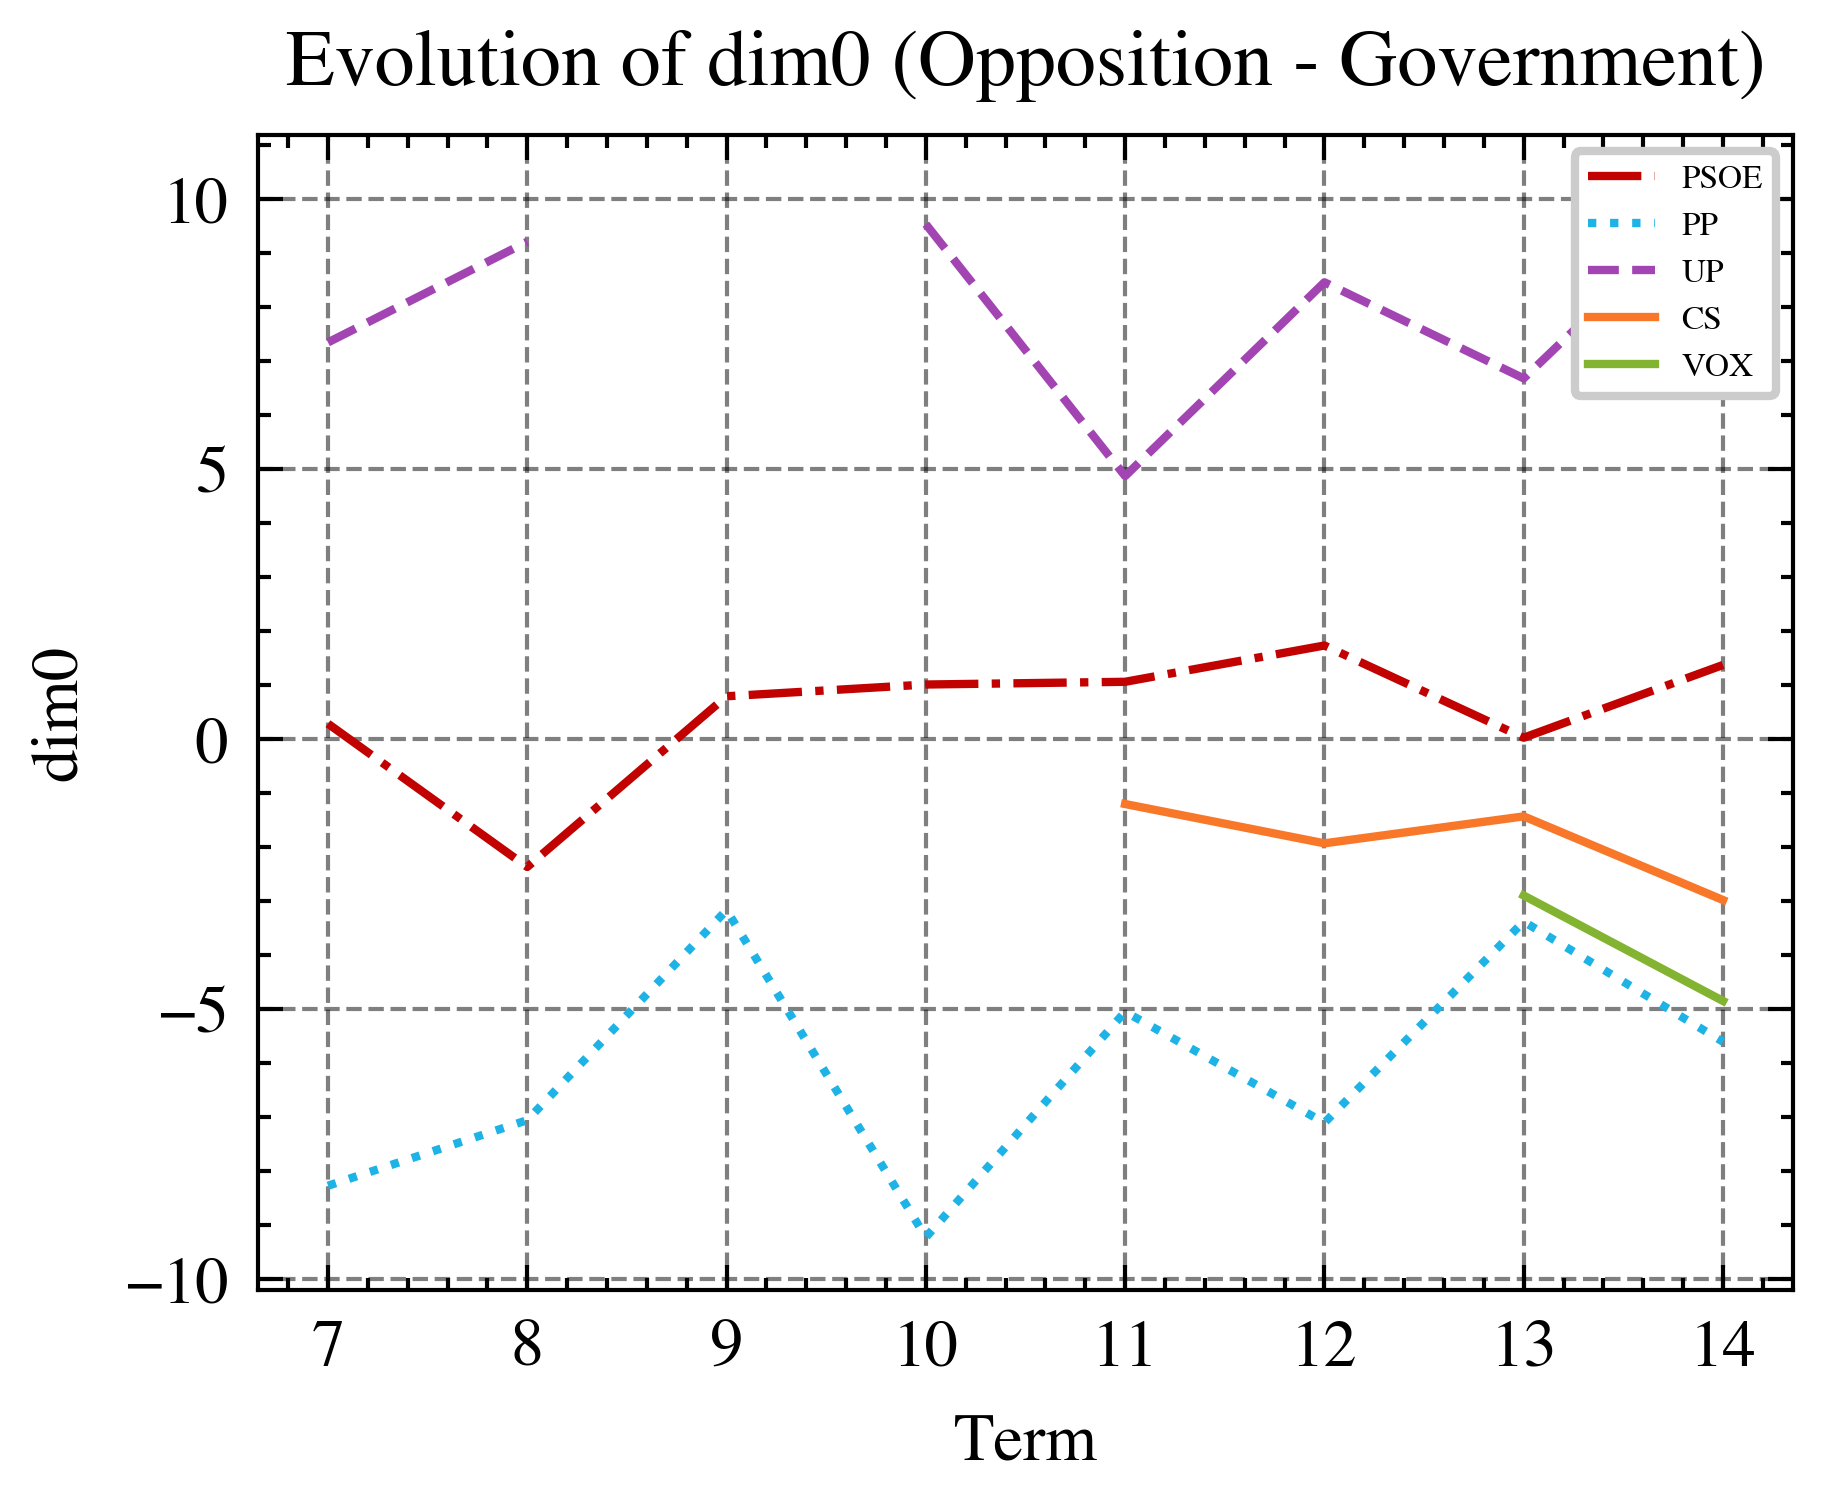

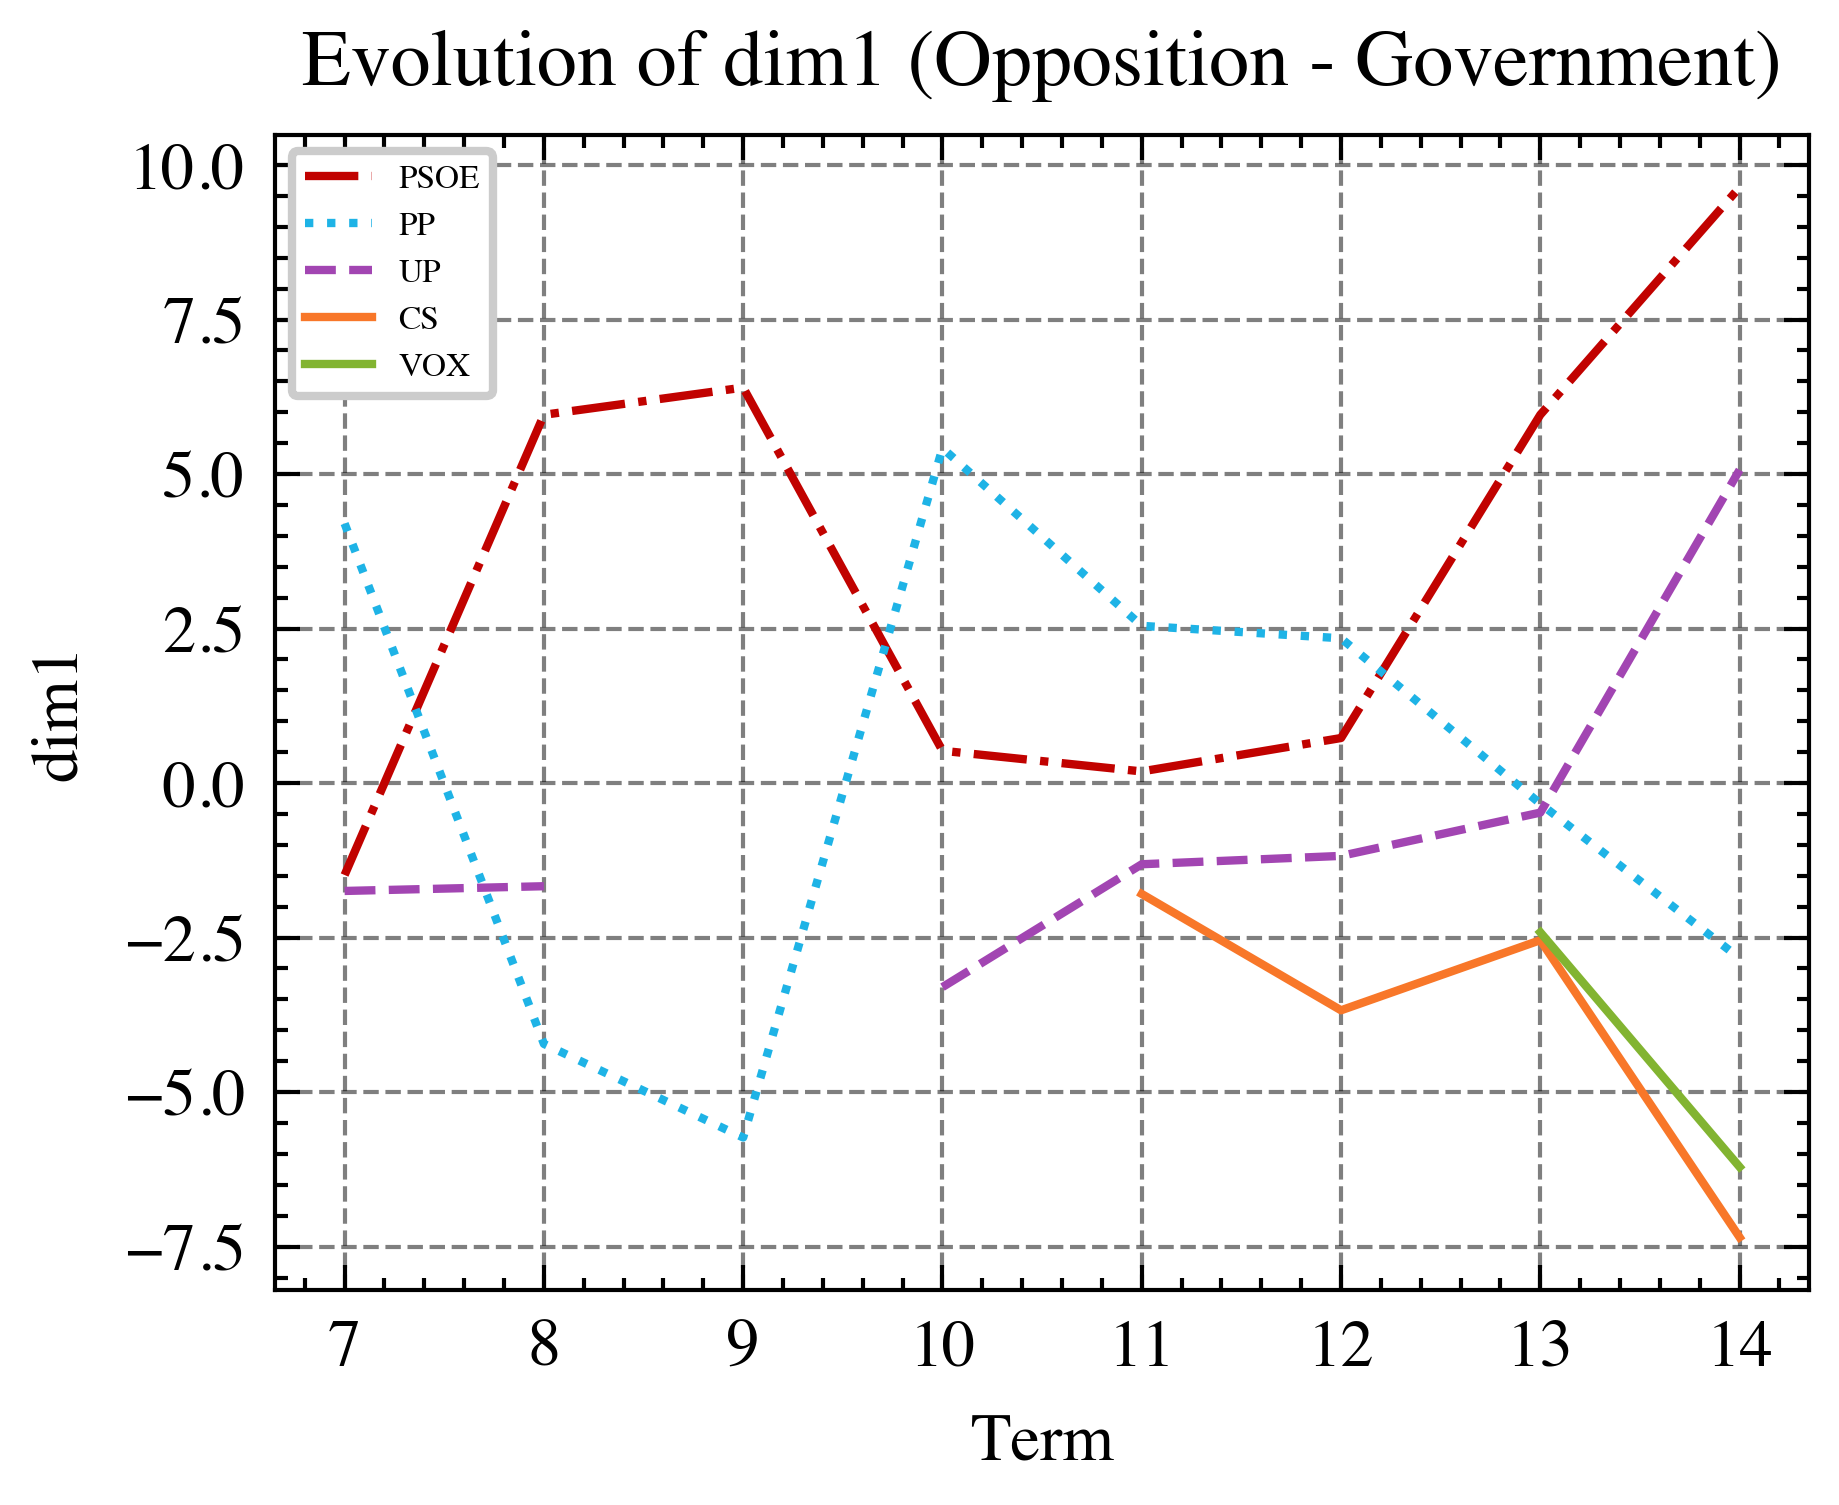

In [16]:
# Dimesions plot.
def plot_ts(dim, reduced):

    # Select only political groups:
    rp = reduced.loc[reduced['speaker'].str.contains('-')]

    # Legislature.    
    rp['leg'] = [i[1] for i in rp['speaker'].str.split('-')]
    rp['party'] = [i[0] for i in rp['speaker'].str.split('-')]

    # Pivot.
    rp['leg'] = rp['leg'].astype(int)
    rp = rp.pivot(index='leg', columns='party', values=['dim0', 'dim1'])

    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Plot each time series on the same axis
    ax.plot(rp[f'{dim}', 'PSOE']*0.31, label='PSOE', color='#c10200', linestyle='-.')
    ax.plot(rp[f'{dim}', 'PP']*0.31, label='PP', color='#1eb3e6', linestyle=':')
    ax.plot(rp[f'{dim}', 'UP']*0.31, label='UP', color='#a245b2', linestyle='--')
    ax.plot(rp[f'{dim}', 'CS']*0.31, label='CS', color='#f87729', linestyle='-')
    ax.plot(rp[f'{dim}', 'VOX']*0.31, label='VOX', color='#82b431', linestyle='-')


    # Add a legend and set the title
    ax.set_title(f'Evolution of {dim} (Opposition - Government)')
    ax.legend(fontsize=4)
    plt.xlabel('Term')
    plt.ylabel(f'{dim}')
    plt.xticks(ticks=[7,8,9,10,11,12,13,14])

    # Show the plot
    plt.show()

plot_ts('dim0', reduced)
plot_ts('dim1', reduced)
#plot_ts('dim2', reduced)


In [17]:
dr.explained_variance_ratio_

array([0.36914486, 0.20986821])

In [29]:
def interpret(emb, pca, N, min_count, max_count, topn) -> list:

    # List all the tokens sorted by ocurrence in the corpus.
    words = emb.wv.index_to_key

    max = reduced.max()
    min = reduced.min()

    wl = []
    for w in words:
        wl.append((w, emb.wv.get_vecattr(w, 'count')))

    selected_wl = [word for word, c in wl if c > min_count and c < max_count]

    if len(selected_wl) < N:
        N = len(selected_wl)
        print(f'Size of selected_wl is smaller than N. N is now = {N}')

    selected_wl = selected_wl[0:N]

    # Reduce the vectors for each selected word using the PCA model to a 2D vector.
    M = np.zeros((N, 2))
    for i, w in enumerate(selected_wl):
        M[i, :] = pca.transform(emb.wv[w].reshape(1, -1))

    # Compute euclidean distances to each corner of the reduced embedding space.
    right = euclidean_distances(M, np.array([max[0], 0]).reshape(1, -1))
    left = euclidean_distances(M, np.array([min[0], 0]).reshape(1, -1))
    up = euclidean_distances(M, np.array([0, max[1]]).reshape(1, -1))
    down = euclidean_distances(M, np.array([0, min[1]]).reshape(1, -1))

    similarities = pd.DataFrame({
        'word': selected_wl,
        'right': right[:, 0],
        'left': left[:, 0],
        'up': up[:, 0],
        'down': down[:, 0]})

    pp = pprint.PrettyPrinter(width=150)

    pp.pprint('Words associated with possitive values of the first PCA component (right):')
    pp.pprint(80*'-')
    pp.pprint(similarities.sort_values(by='right')['word'].tolist()[0:topn])

    pp.pprint('Words associated with negative values of the first PCA component (left):')
    pp.pprint(80*'-')
    pp.pprint(similarities.sort_values(by='left')['word'].tolist()[0:topn])

    pp.pprint('Words associated with possitive values of the second PCA component (up):')
    pp.pprint(80*'-')
    pp.pprint(similarities.sort_values(by='up')['word'].tolist()[0:topn])

    pp.pprint('Words associated with negative values of the second PCA component (down):')
    pp.pprint(80*'-')
    pp.pprint(similarities.sort_values(by='down')['word'].tolist()[0:topn])

    return M, selected_wl

m, wl = interpret(model, dr, 10000, 200, 10000, 50)

'Words associated with possitive values of the first PCA component (right):'
'--------------------------------------------------------------------------------'
['recortes',
 'derechos_laborales',
 'privatización',
 'trabajadores_trabajadoras',
 'ciudadanía',
 'recorte',
 'privatizaciones',
 'planteamos',
 'derechos_sociales',
 'grandes_empresas',
 'cuidados',
 'poderosos',
 'derechas',
 'movimiento_feminista',
 'organizaciones_sociales',
 'movilizaciones',
 'planteábamos',
 'neoliberal',
 'recortar',
 'salario_mínimo',
 'sanidad_pública',
 'trabajadoras',
 'trillo',
 'ambiental',
 'montoro',
 'desahucios',
 'sindical',
 'ultraderecha',
 'precariedad',
 'servicios_públicos',
 'estafa',
 'especulación',
 'gallardón',
 'empresas_privadas',
 'grandes_corporaciones',
 'paraísos_fiscales',
 'derecha',
 'represión',
 'lgtbi',
 'entendíamos',
 'troika',
 'grandes_fortunas',
 'sindicatos',
 'inversión_pública',
 'franquismo',
 'pública',
 'iglesia_católica',
 'salarios',
 'eléctricas',
 'franqu

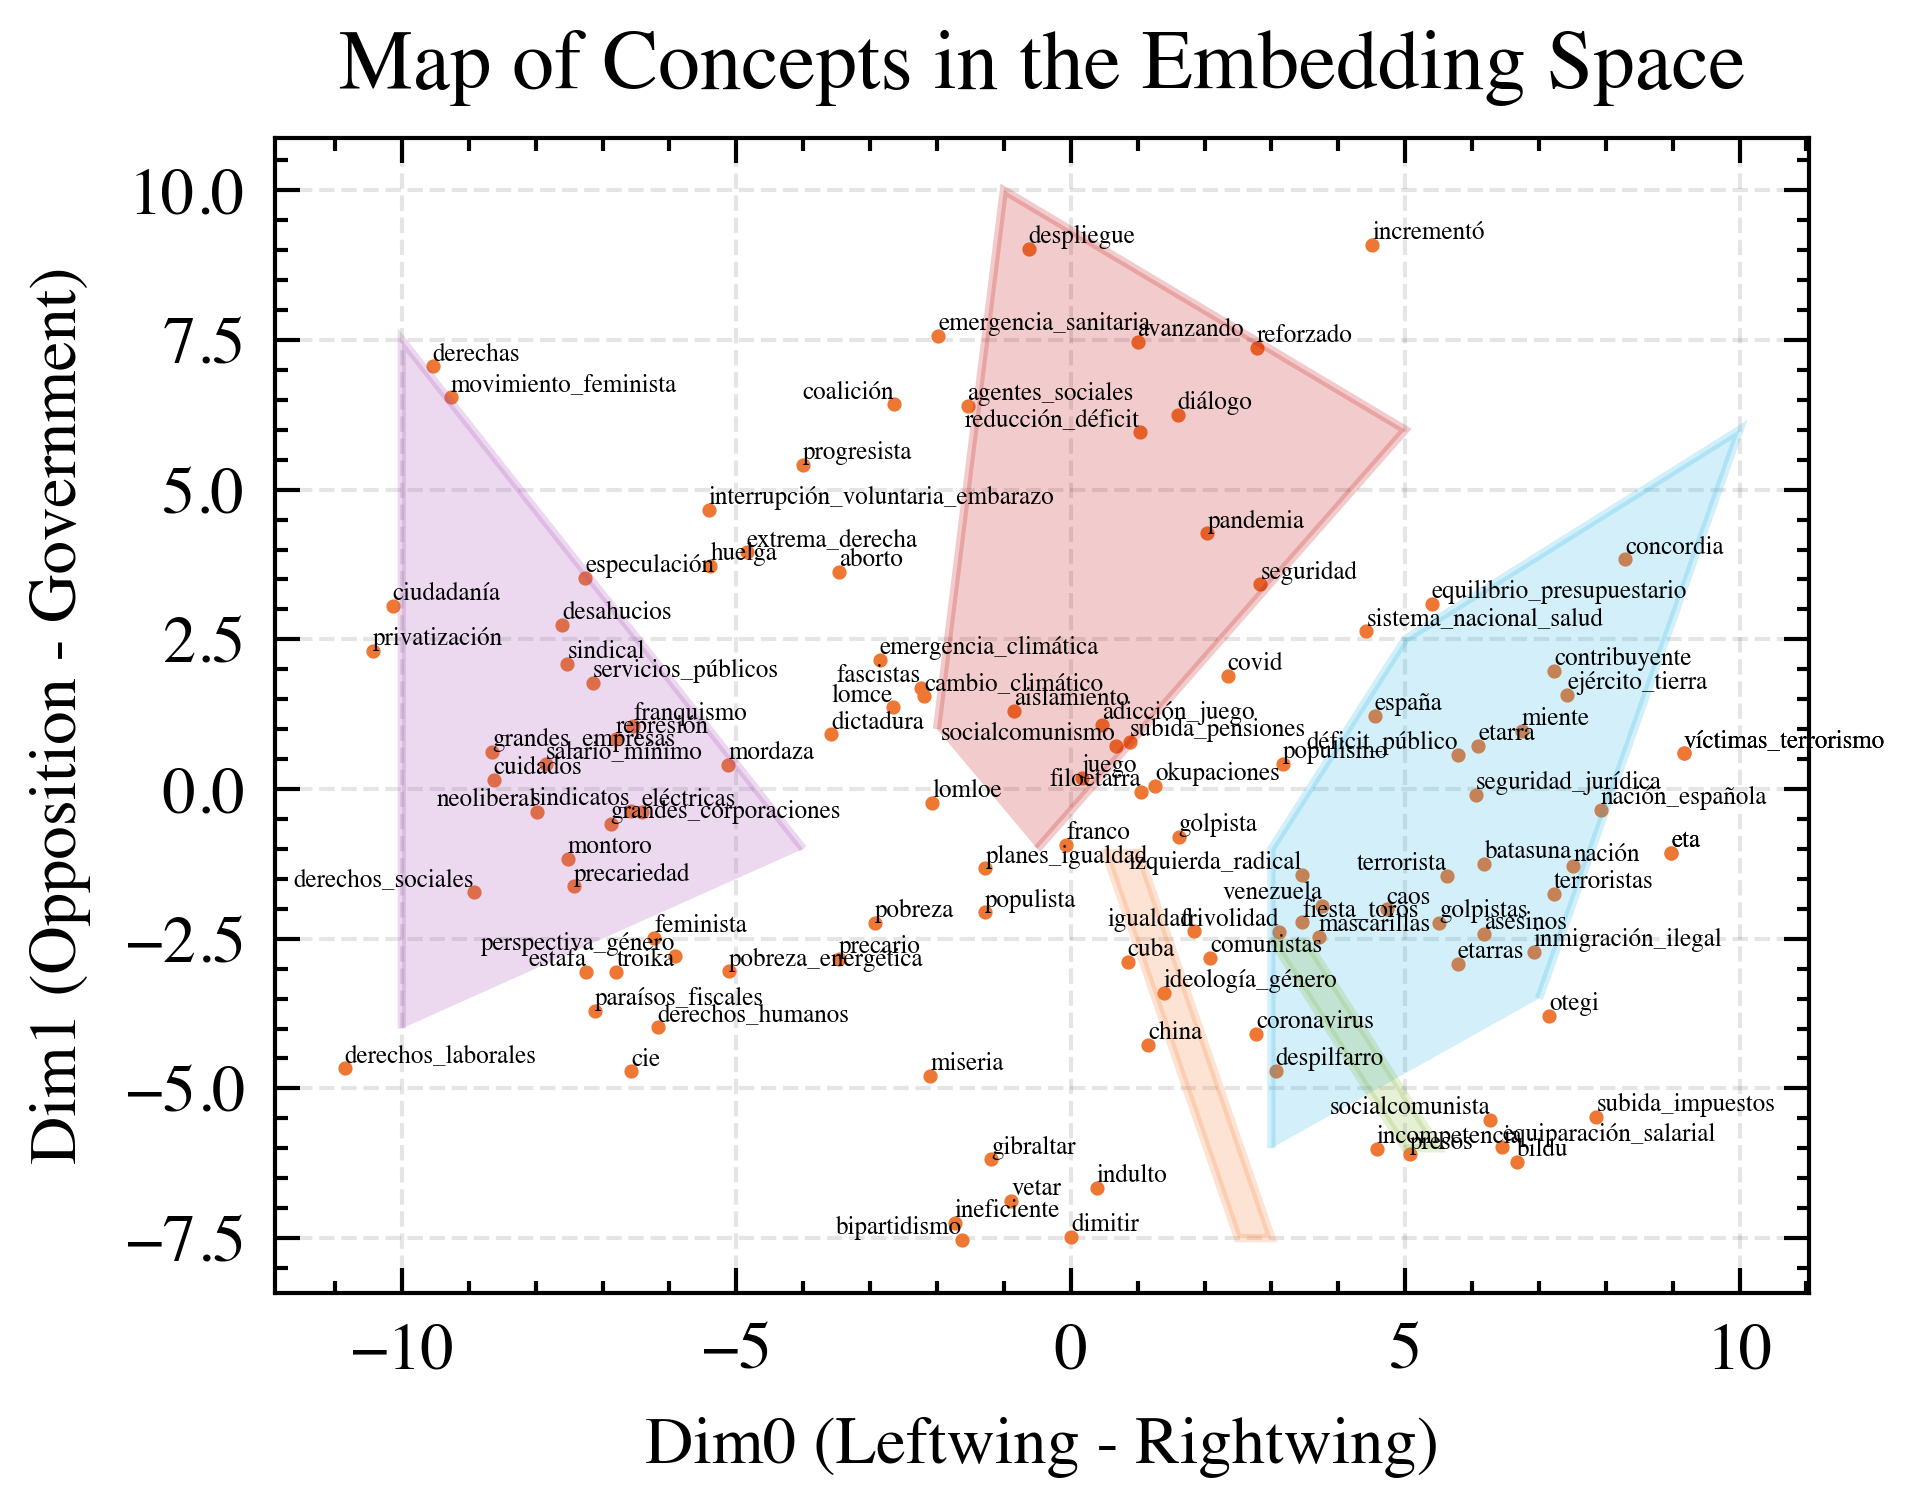

In [11]:
from matplotlib.patches import Polygon

def reference_concepts(emb, pca):

    concepts = ['fiesta_toros', 'subida_impuestos', 'equilibrio_presupuestario', 'despilfarro', 'progresista', 'bipartidismo', 'ciudadanía', 'sistema_nacional_salud',
                'derechos_sociales', 'emergencia_climática', 'cambio_climático', 'ideología_género', 'perspectiva_género', 'frivolidad', 'miseria', 'nación',
                'movimiento_feminista', 'extrema_derecha', 'derechas', 'equiparación_salarial', 'servicios_públicos', 'franco', 'indulto', 'ejército_tierra',
                'derechos_laborales', 'privatización',  'grandes_empresas', 'especulación', 'precario', 'precariedad', 'diálogo', 'grandes_corporaciones', 'caos',
                'salario_mínimo', 'derechos_humanos', 'desahucios', 'okupaciones', 'sindicatos', 'sindical', 'huelga', 'franquismo', 'cuidados', 'contribuyente',
                'represión', 'feminista', 'paraísos_fiscales', 'pobreza', 'pobreza_energética', 'eta', 'víctimas_terrorismo', 'concordia', 'nación_española',
                'asesinos', 'terroristas', 'terrorista', 'socialcomunista', 'socialcomunismo', 'filoetarra', 'fascistas', 'comunistas', 'eléctricas', 'incompetencia',
                'otegi', 'etarras', 'eta', 'etarra', 'juego', 'adicción_juego', 'lomloe', 'lomce', 'populista', 'populismo', 'seguridad_jurídica', 'inmigración_ilegal',
                'planes_igualdad', 'igualdad', 'mordaza', 'presos', 'mascarillas', 'covid', 'subida_pensiones', 'golpista', 'golpistas', 'estafa', 'despliegue', 'reforzado',
                'interrupción_voluntaria_embarazo', 'aborto', 'izquierda_radical', 'españa', 'venezuela', 'cuba', 'coronavirus', 'aislamiento', 'pandemia', 'avanzando',
                'troika', 'batasuna', 'ineficiente', 'bildu', 'china', 'gibraltar', 'coalición', 'seguridad', 'neoliberal', 'déficit_público', 'miente', 'incrementó',
                'agentes_sociales', 'reducción_déficit', 'emergencia_sanitaria', 'dimitir', 'montoro', 'vetar', 'dictadura', 'víctimas_terrorismo', 'cie'] #, 'izquierda', 'sanidad_pública', , 'condiciones_laborales']

    M = np.zeros((len(concepts), 2))

    for i, w in enumerate(concepts):
        M[i, :] = pca.transform(emb.wv[w].reshape(1, -1))

    words = pd.DataFrame({'word': concepts})
    words['x'] = M[:, 0]
    words['y'] = M[:, 1]
    words['x'] = words['x'] * -1 # So that leftwing is on the left and vice-versa.

    return words

def plot_w(w):

    fig, ax = plt.subplots()

    ax.scatter(w.x, w.y, marker='.', s=2)

    label_list = ['coalición', 'reducción_déficit', 'socialcomunismo', 'filoetarra', 'derechos_sociales', 'lomce', 'fascistas', 'igualdad', 'izquierda_radical', 'socialcomunista',
                  'terrorista', 'déficit_público', 'estafa', 'perspectiva_género', 'bipartidismo', 'frivolidad', 'sindicatos', 'neoliberal', 'venezuela']

    for label, x, y in zip(w.word, w.x, w.y):
        if label not in label_list:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), fontsize=3,
                         textcoords='offset points', ha='left',
                         va='bottom')
        else:
            ax.annotate(label, xy=(x, y), xytext=(0, 0), fontsize=3, 
                                  textcoords='offset points', ha='right', 
                                  va='bottom')

    ax.set_title('Map of Concepts in the Embedding Space', fontsize=10)
    ax.grid(alpha=.1)
    ax.set_xlabel('Dim0 (Leftwing - Rightwing)')
    ax.set_ylabel('Dim1 (Opposition - Government)')

    p = Polygon([[-2, 1], [-1, 10], [5, 6], [-.5, -1]],
                closed=False, alpha=.2, color='#c10200')
    p2 = Polygon([[-10, -4], [-10, 7.5], [-4, -1]],
                 closed=False, alpha=.2, color='#a245b2')
    
    p3 = Polygon([[3, -6], [3, -1], [5, 2.5], [10, 6], [7, -3.5], [3, -6]],
                 closed=False, alpha=.2, color='#1eb3e6')
    
    p4 = Polygon([[1, -1], [3, -7.5], [2.5, -7.5], [.5, -1]],
                 closed=False, alpha=.2, color='#f87729')
    
    p5 = Polygon([[3, -2.5], [5, -6], [5.5, -6], [3.5, -2.5]],
                 closed=False, alpha=.2, color='#82b431')
    
    ax.add_patch(p)
    ax.add_patch(p2)
    ax.add_patch(p3)
    ax.add_patch(p4)
    ax.add_patch(p5)

words = reference_concepts(model, dr)
plot_w(words)


In [75]:
model0.wv.most_similar(model0['PP-14'], topn=20)

[('sánchez', 0.6820895075798035),
 ('ábalos', 0.5288954973220825),
 ('socialcomunista', 0.5243410468101501),
 ('pedro_sánchez', 0.5124534368515015),
 ('zapatero', 0.5030941963195801),
 ('populistas_independentistas', 0.5000870227813721),
 ('españoles', 0.49598854780197144),
 ('celaá', 0.49147742986679077),
 ('doctor_sánchez', 0.4879920482635498),
 ('sanchismo', 0.48121178150177),
 ('preguntamos', 0.4746611714363098),
 ('incapacidad', 0.47308728098869324),
 ('soberbia', 0.47245630621910095),
 ('moncloa', 0.4720447063446045),
 ('incompetencia', 0.4684739410877228),
 ('caos', 0.46742987632751465),
 ('marlaska', 0.45655694603919983),
 ('ribera', 0.45488423109054565),
 ('socios_separatistas', 0.44498297572135925),
 ('rodrí_guez_zapatero', 0.4445037841796875)]

In [103]:
t = model0.dv.most_similar(model0.wv['movimiento_feminista'], topn=50)
t

[('UP-14', 0.5224407911300659),
 ('UP-12', 0.3731552064418793),
 ('UP-13', 0.37148481607437134),
 ('UP-7', 0.3566135764122009),
 ('UP-11', 0.35512495040893555),
 ('UP-8', 0.33211755752563477),
 ('PSOE-14', 0.330579936504364),
 ('PSOE-9', 0.28966543078422546),
 ('PSOE-12', 0.2760566771030426),
 ('L12', 0.24114122986793518),
 ('PSOE-13', 0.22841118276119232),
 ('L14', 0.2170487344264984),
 ('L08', 0.21367883682250977),
 ('UP-10', 0.1929045468568802),
 ('L13', 0.1858474612236023),
 ('PSOE-11', 0.18204034864902496),
 ('L11', 0.17769499123096466),
 ('PSOE-8', 0.14370907843112946),
 ('L07', 0.04833262041211128),
 ('L09', 0.014874288812279701),
 ('L10', 0.011547076515853405),
 ('CS-13', -0.06603635847568512),
 ('PSOE-10', -0.10976430028676987),
 ('PSOE-7', -0.13934512436389923),
 ('PP-7', -0.16507624089717865),
 ('CS-12', -0.2031967043876648),
 ('PP-12', -0.20852723717689514),
 ('PP-10', -0.21277739107608795),
 ('PP-11', -0.2132570594549179),
 ('CS-14', -0.2181994915008545),
 ('CS-11', -0.220

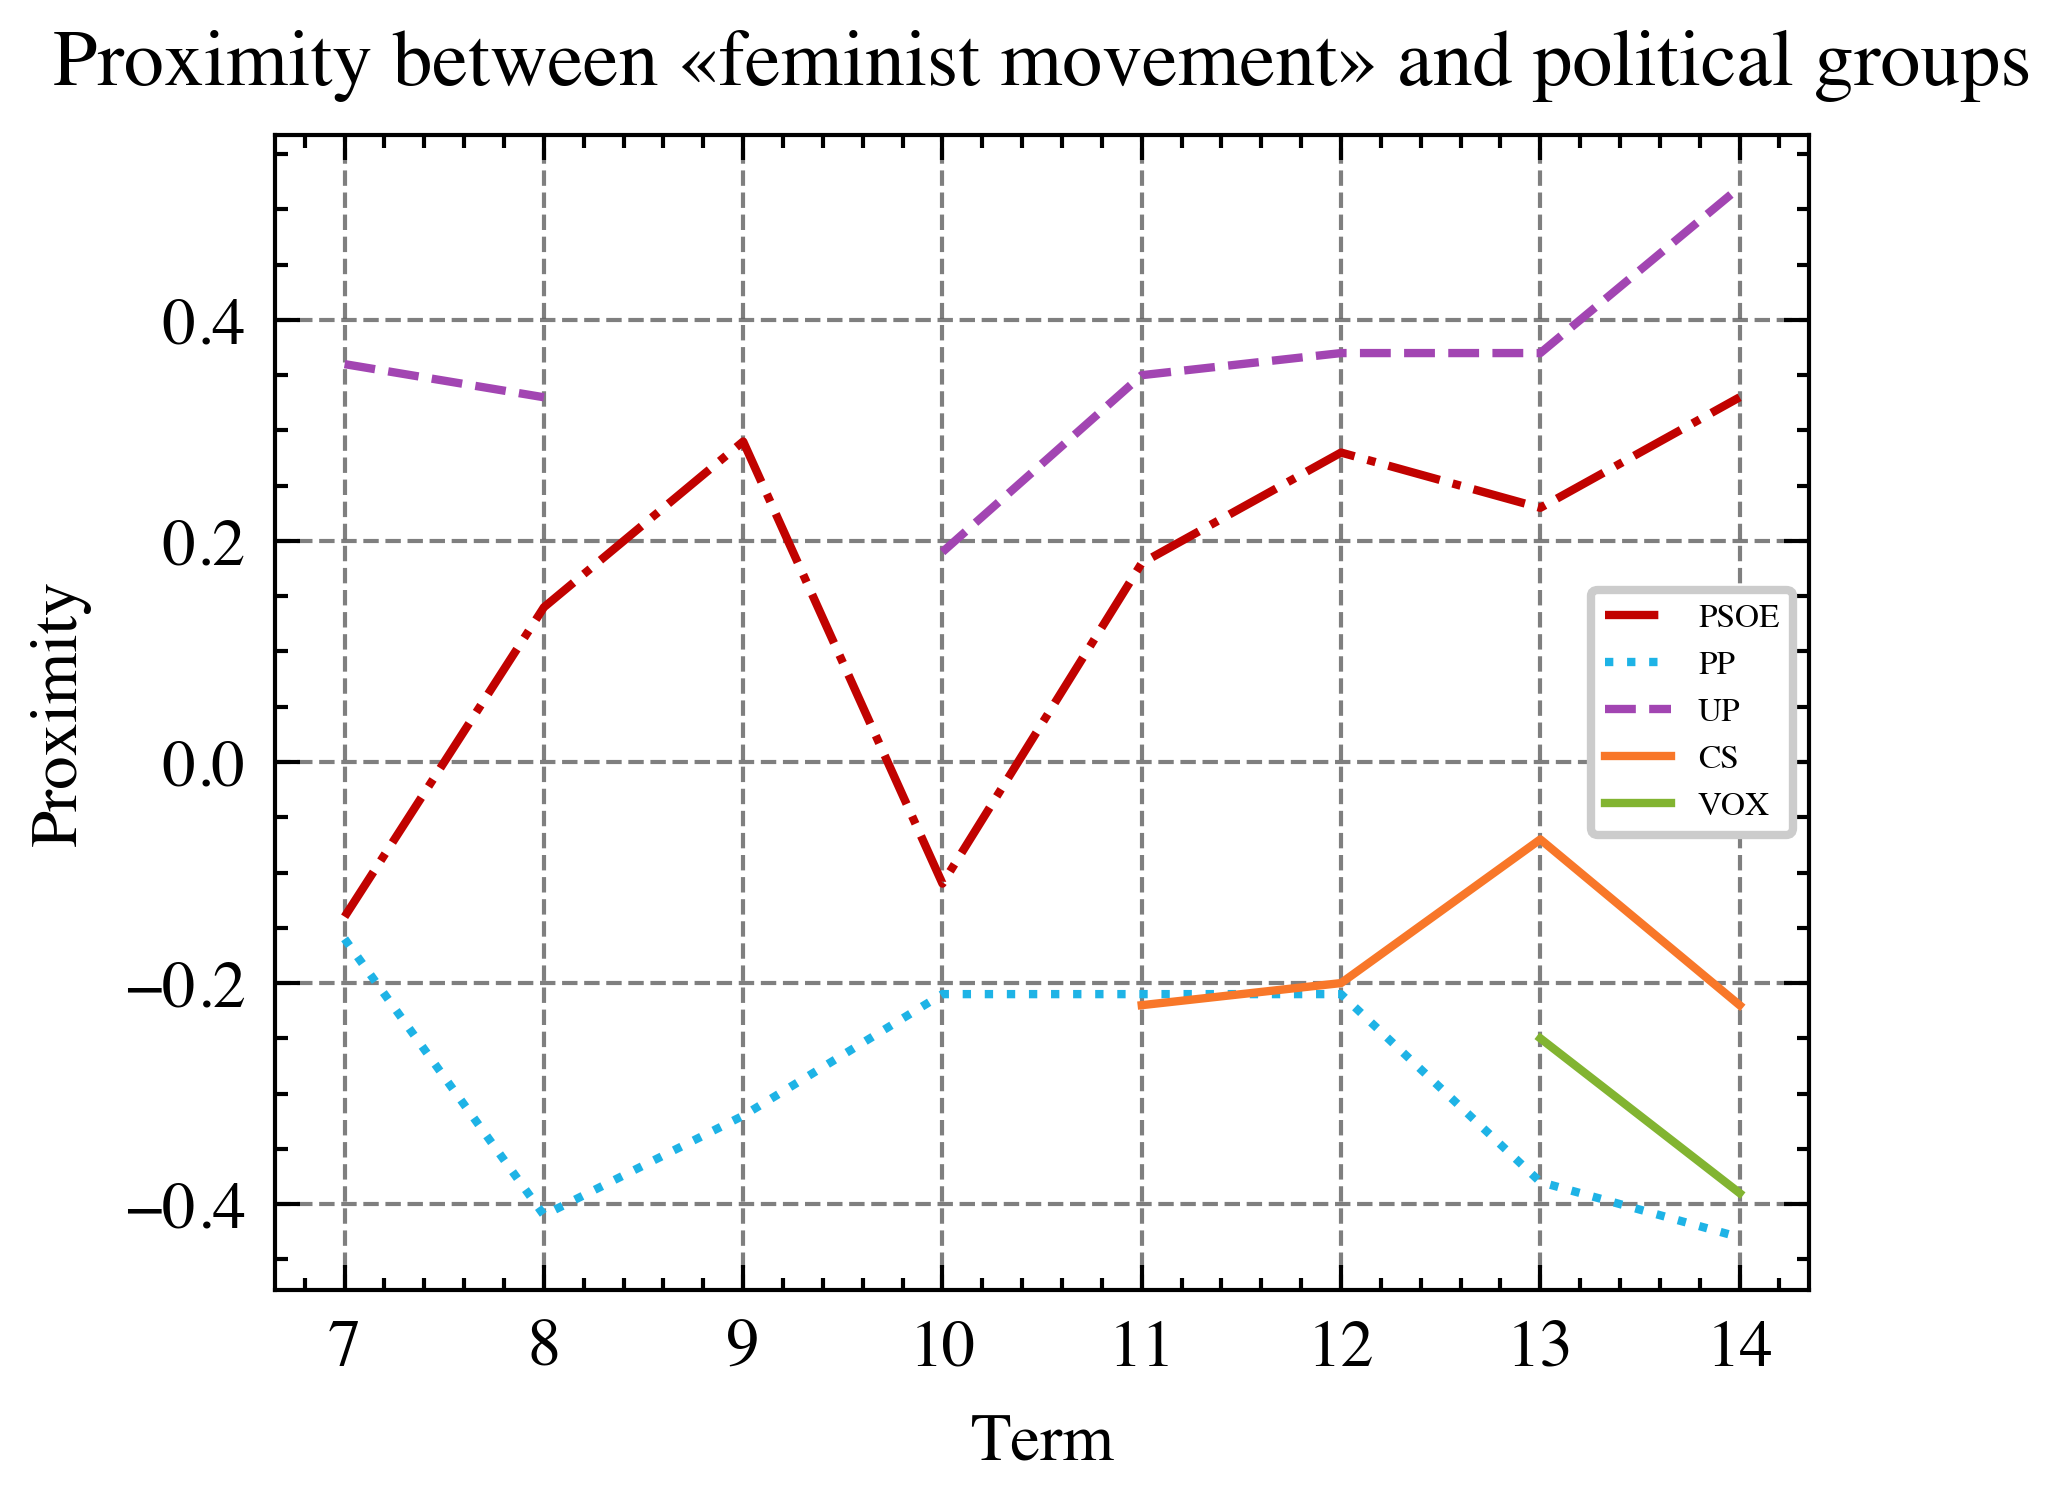

In [19]:
le = np.array([7, 8, 9, 10, 11, 12, 13, 14])
UP_mf = np.array([0.36, 0.33, np.nan, 0.19, 0.35, 0.37, 0.37, 0.52])
PSOE_mf = np.array([-0.14, 0.14, 0.29, -0.11, 0.18, 0.28, 0.23, 0.33])
PP_mf = np.array([-0.16, -0.41, -0.32, -0.21, -0.21, -0.21, -0.38, -0.43])
VOX_mf = np.array([np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, -0.25, -0.39])
CS_mf = np.array([np.nan, np.nan, np.nan, np.nan, -0.22, -0.20, -0.07, -0.22])

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot each time series on the same axis
ax.plot(le, PSOE_mf, label='PSOE', color='#c10200', linestyle='-.')
ax.plot(le, PP_mf, label='PP', color='#1eb3e6', linestyle=':')
ax.plot(le, UP_mf, label='UP', color='#a245b2', linestyle='--')
ax.plot(le, CS_mf, label='CS', color='#f87729', linestyle='-')
ax.plot(le, VOX_mf, label='VOX', color='#82b431', linestyle='-')

# Add a legend and set the title
ax.set_title(f'Proximity between «feminist movement» and political groups')
ax.legend(fontsize=4)
plt.xlabel('Term')
plt.ylabel(f'Proximity')
plt.xticks(ticks=[7, 8, 9, 10, 11, 12, 13, 14])

# Show the plot
plt.show()

In [32]:
M = np.zeros((len(model.wv.index_to_key), 2))

for i, w in enumerate(model.wv.index_to_key):
    M[i, :] = dr.transform(model.wv[w].reshape(1, -1))

words = pd.DataFrame({'word': model.wv.index_to_key})
words['x'] = M[:, 0]
words['y'] = M[:, 1]
words

,word,x,y
0,españa,-4.547638,1.215675
1,año,-2.540833,2.898794
2,ser,0.914699,-4.835831
3,país,3.209663,1.620283
4,puede,-0.538620,-1.688394
...,...,...,...
159769,disminuiremos,-0.407166,0.635586
159770,envuelvan,-0.707423,0.281956
159771,enviado_especial_baker,-0.582512,0.412140
159772,ratificó_protocolo,-0.863611,0.499913


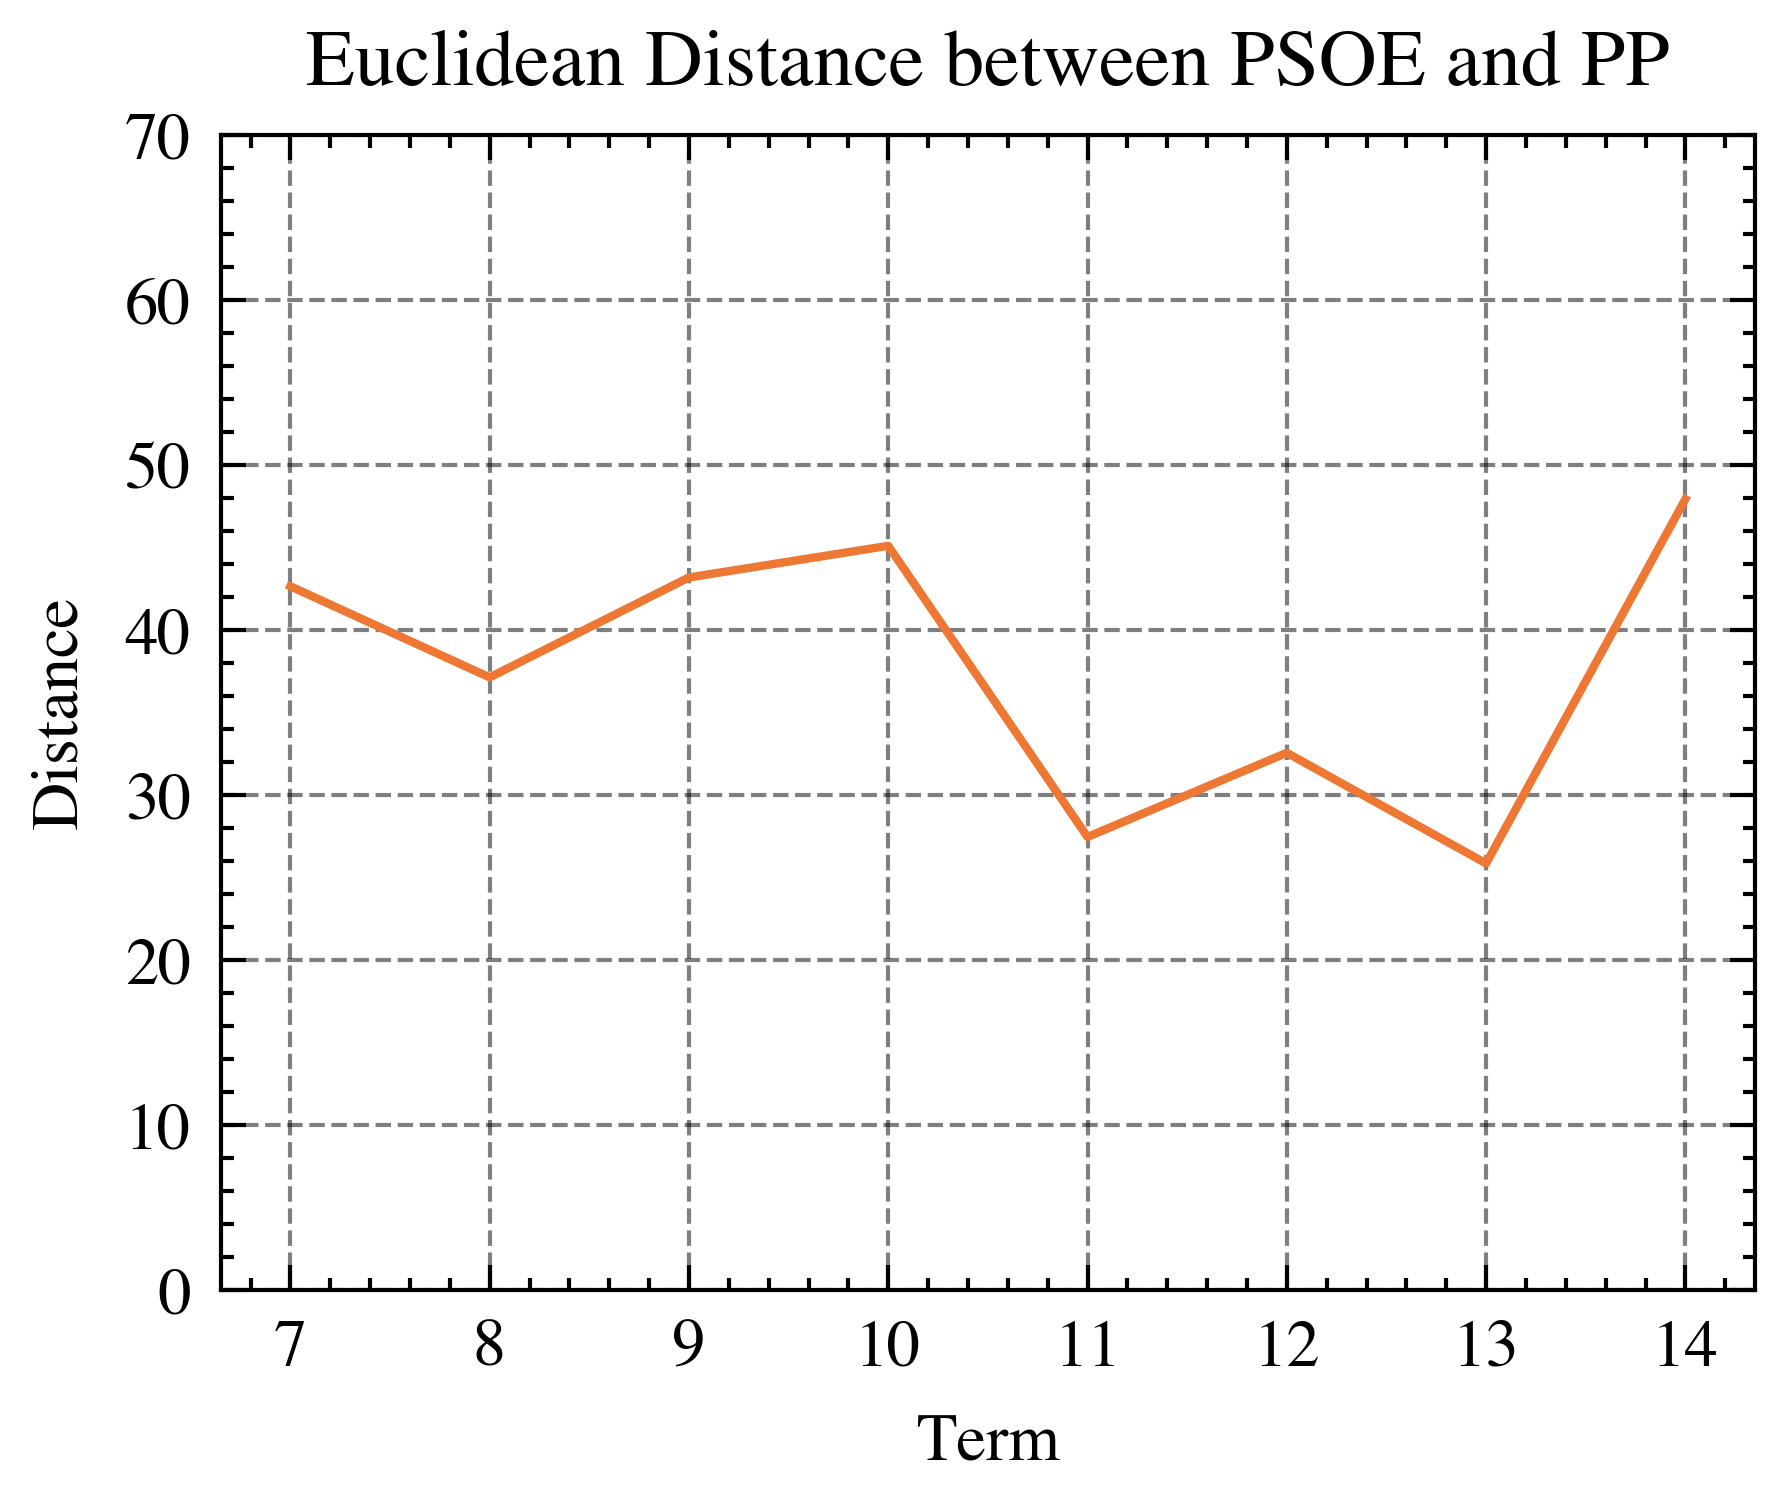

In [21]:
from scipy import spatial

fig, ax = plt.subplots()
le2 = [11, 12, 13, 14]

dis = []
for l in le:
    try:
        dis.append(spatial.distance.euclidean(
            model[f'PSOE-{l}'], model[f'PP-{l}']))
    except:
        dis.append(np.nan)

ax.plot(le, dis)

ax.set_title(f'Euclidean Distance between PSOE and PP')
plt.xlabel('Term')
plt.ylabel(f'Distance')
plt.xticks(ticks=[7, 8, 9, 10, 11, 12, 13, 14])
plt.yticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70])
plt.show()


In [125]:
rp = reduced.loc[reduced['speaker'].str.contains('-')]

# Legislature.
rp['leg'] = [i[1] for i in rp['speaker'].str.split('-')]
rp['party'] = [i[0] for i in rp['speaker'].str.split('-')]

# Pivot.
rp['leg'] = rp['leg'].astype(int)
rp = rp.pivot(index='leg', columns='party', values=['dim0', 'dim1'])

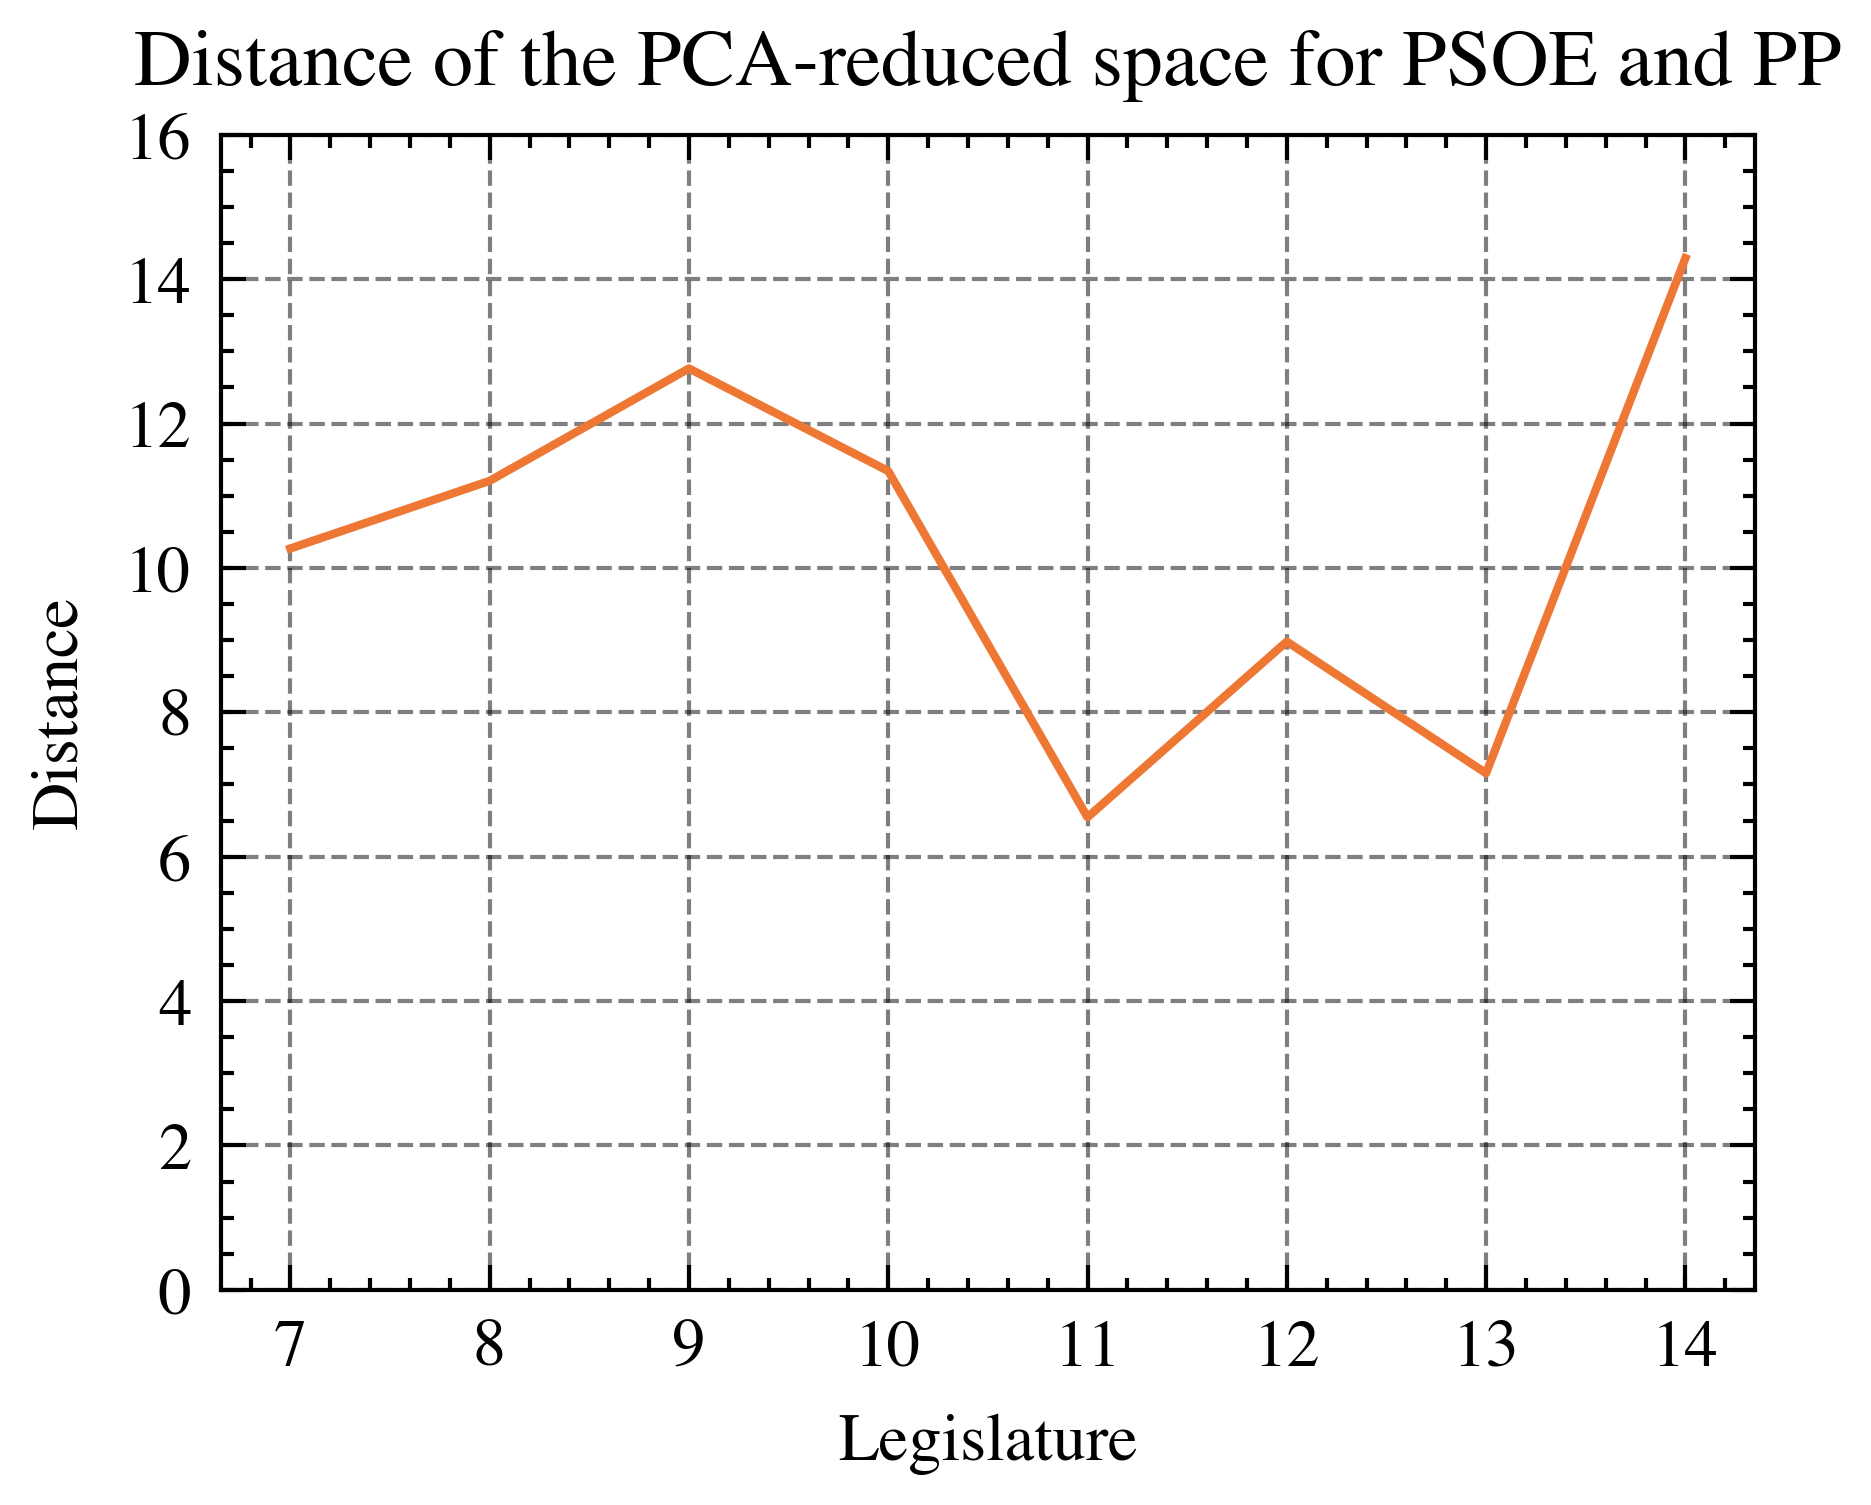

In [148]:
tpsoe = np.array([[rp['dim0', 'PSOE'][i]*0.31, rp['dim1', 'PSOE'][i]*0.31] for i in le])
tpp = np.array([[rp['dim0', 'PP'][i]*0.31, rp['dim1', 'PP'][i]*0.31] for i in le])
distances = [spatial.distance.euclidean(tpsoe[i], tpp[i]) for i in range(8)]

fig, ax = plt.subplots()
ax.plot(le, distances)
ax.set_title(f'Distance of the PCA-reduced space for PSOE and PP')
plt.xlabel('Legislature')
plt.ylabel(f'Distance')
plt.xticks(ticks=[7, 8, 9, 10, 11, 12, 13, 14])
plt.yticks(ticks=[0, 2, 4, 6, 8, 10, 12, 14, 16])
plt.show()


In [63]:
test = pd.DataFrame(cos_distances, model.wv.index_to_key)
test.columns = ['d-UP-14']

In [65]:
test.min()

d-UP-14    34.129841
dtype: float64

In [66]:
test.loc[test['d-UP-14'] < 35]

,d-UP-14
trabajadores_trabajadoras,34.721462
derechas,34.129841
